

# Recurrent Neural Networks and Long Short Term Memory (LSTM)

tensorflow gpu as well as the Cuda library should be used to run this locally. 

![Alice in Wonderland](http://giphygifs.s3.amazonaws.com/media/N8OXS6RFwnBkI/giphy.gif)

Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the Alice in Wonderland book used: https://gist.githubusercontent.com/phillipj/4944029/raw/75ba2243dd5ec2875f629bf5d79f6c1e4b5a8b46/alice_in_wonderland.txt

Using a character LSTM, the network will generate Lewis Carrol like text based on the book.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Activation
print(device_lib.list_local_devices()) #make sure the GPU is exposed 
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #make sure the GPU is used backend vs Theanos
import numpy as np
import os
import re
import time
import string

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12759512152499244626
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6622735237
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10551985994170035563
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
# load text
filename = 'D:\Githubrepos\DS-Unit-4-Sprint-3-Deep-Learning\module1-rnn-and-lstm\Alice.txt'
file = open(filename, 'rt')
text = file.read()
file.close()
# split into words by white space

words = text.strip()
words = words.replace('\n',' \n  ')
# remove punctuation from each word
string.punctuation = string.punctuation.replace(".","")
string.punctuation = string.punctuation.replace("?","")
string.punctuation = string.punctuation.replace("!","")
table = str.maketrans('', '', string.punctuation)
raw_text = [w.translate(table) for w in words]
stripped = "".join(raw_text)
stripped = stripped[22:]
print(stripped[:350])

 
   
   
  Alice was beginning to get very tired of sitting by her sister on the 
  bank and of having nothing to do. Once or twice she had peeped into the 
  book her sister was reading but it had no pictures or conversations in 
  it and what is the use of a book thought Alice without pictures or 
  conversations? 
   
  So she was considering i


In [3]:
# Take a look at the first 250 characters in text
print(stripped[:250])

 
   
   
  Alice was beginning to get very tired of sitting by her sister on the 
  bank and of having nothing to do. Once or twice she had peeped into the 
  book her sister was reading but it had no pictures or conversations in 
  it and what is t


In [4]:
# The unique characters in the file
vocab = sorted(set(stripped))
print ('{} unique characters'.format(len(vocab)))
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(stripped)))

57 unique characters
Length of text: 54454 characters


In [5]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in stripped])


In [6]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '.' :   3,
  '?' :   4,
  'A' :   5,
  'B' :   6,
  'C' :   7,
  'D' :   8,
  'E' :   9,
  'F' :  10,
  'G' :  11,
  'H' :  12,
  'I' :  13,
  'J' :  14,
  'K' :  15,
  'L' :  16,
  'M' :  17,
  'N' :  18,
  'O' :  19,
  ...
}


In [7]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(stripped[:13]), text_as_int[:13]))


' \n   \n   \n  A' ---- characters mapped to int ---- > [1 0 1 1 1 0 1 1 1 0 1 1 5]


In [8]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(stripped)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])


In [9]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(8):
  print(repr(''.join(idx2char[item.numpy()])))

' \n   \n   \n  Alice was beginning to get very tired of sitting by her sister on the \n  bank and of havi'
'ng nothing to do. Once or twice she had peeped into the \n  book her sister was reading but it had no '
'pictures or conversations in \n  it and what is the use of a book thought Alice without pictures or \n '
' conversations? \n   \n  So she was considering in her own mind as well as she could for the \n  day mad'
'e her feel very sleepy and stupid whether the pleasure of \n  making a daisychain would be worth the t'
'rouble of getting up and \n  picking the daisies when suddenly a White Rabbit with pink eyes ran \n  cl'
'ose by her. \n   \n  There was nothing so very remarkable in that nor did Alice think it so \n  very muc'
'h out of the way to hear the Rabbit say to itself Oh dear! Oh \n  dear! I shall be too late! But when '


In [10]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)


In [11]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))


Input data:  ' \n   \n   \n  Alice was beginning to get very tired of sitting by her sister on the \n  bank and of hav'
Target data: '\n   \n   \n  Alice was beginning to get very tired of sitting by her sister on the \n  bank and of havi'


In [12]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))


Step    0
  input: 1 (' ')
  expected output: 0 ('\n')
Step    1
  input: 0 ('\n')
  expected output: 1 (' ')
Step    2
  input: 1 (' ')
  expected output: 1 (' ')
Step    3
  input: 1 (' ')
  expected output: 1 (' ')
Step    4
  input: 1 (' ')
  expected output: 0 ('\n')


In [13]:
# Batch size
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

In [14]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


In [15]:
if tf.test.is_gpu_available():
  rnn = tf.keras.layers.CuDNNGRU
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')


In [16]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        rnn(rnn_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True),
        rnn(rnn_units,
            return_sequences=True,
            recurrent_initializer='glorot_uniform',
            stateful=True),
    
        tf.keras.layers.Dense(vocab_size)])
    
    return model


In [17]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)


In [18]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
model.summary()

(64, 100, 57) # (batch_size, sequence_length, vocab_size)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           14592     
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (64, None, 1024)          3938304   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (64, None, 1024)          6297600   
_________________________________________________________________
dense (Dense)                (64, None, 57)            58425     
Total params: 10,308,921
Trainable params: 10,308,921
Non-trainable params: 0
_________________________________________________________________


In [19]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()


In [20]:
sampled_indices

array([19, 43, 38, 51,  9, 20,  6, 35, 32, 15,  5, 38, 53, 41, 17, 48, 48,
       46, 15, 53, 23, 34, 20, 52, 16,  1, 23, 12, 32,  3, 12, 44, 11,  2,
       26, 55, 37, 10, 12, 10, 17,  5,  9,  5, 14, 36, 19, 18, 56, 56, 44,
       54, 36, 47, 10, 13, 48, 48, 49, 24, 24, 42,  2, 35, 21, 40, 50, 48,
       54, 35,  1, 25, 13, 49, 16, 12, 45, 50, 29, 45, 54,  0, 41, 21,  3,
       47, 10, 29, 41, 39, 33, 32, 15, 27, 53, 25, 14,  5, 31, 53],
      dtype=int64)

In [21]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))


Input: 
 'is something comes at me \n  like a Jackinthebox and up I goes like a skyrocket! \n   \n  After a minut'

Next Char Predictions: 
 'OnivEPBfcKAixlMssqKxSePwL SHc.HoG!VzhFHFMAEAJgONùùoygrFIsstTTm!fQkusyf UItLHpuYpy\nlQ.rFYljdcKWxUJAbx'


In [22]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())


Prediction shape:  (64, 100, 57)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.04201


In [23]:
model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)


In [24]:

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

es = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=200)


checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [25]:
EPOCHS=5000


In [26]:
%time
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, verbose=0,callbacks=[checkpoint_callback, es])


Wall time: 0 ns


In [27]:
tf.train.latest_checkpoint(checkpoint_dir)


'./training_checkpoints\\ckpt_1382'

In [28]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))


In [41]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))



In [42]:
#history.history will track the models metrics during training and can be accessed in key value pairs
#this model is only currently tracking training loss but could be expanded to include others with the 
#call back method.
history_dict = history.history
history_dict.keys()

dict_keys(['loss'])

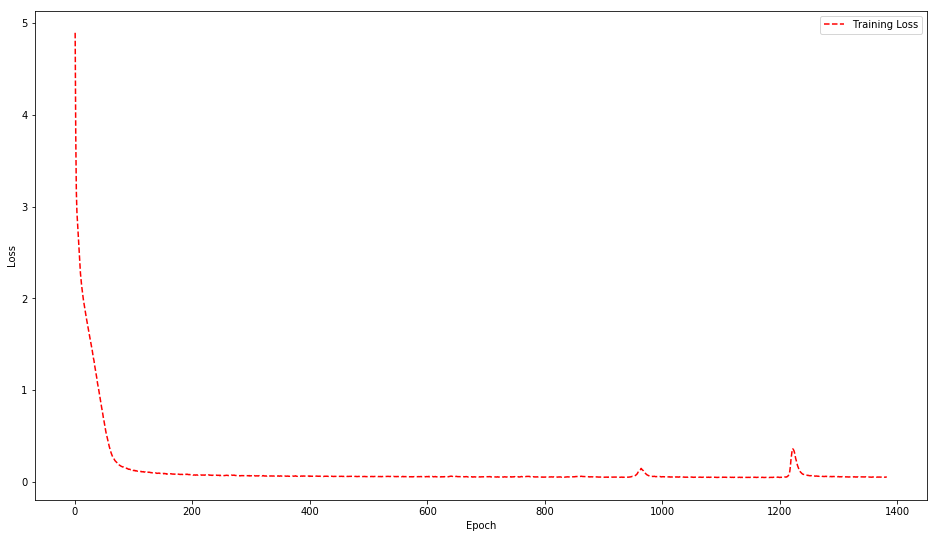

In [52]:
import matplotlib.pyplot as plt
# Get training loss for the model to see if we converged correctly
training_loss = history.history['loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(16,9))
plt.plot(epoch_count, training_loss, 'r--')
#plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The spaces denoted in the training material as \n are preserved
using the print function will format the text in the style of the orginal
Louis Carrol was expressive with his formatting in many parts of the book and 
that can be seen in the models generative result

Additionally, the text of the training material included Illustration place holders
These could come in handy later to place generative images in their stead.

In [56]:
print(generate_text(model, start_string=u"Alice "))


Alice and 
  sighing. 
   
  It is a long tail certainly said Alice looking down with wonder 
  at   
  Well be off then! said the Pigeon in a sulky tone as it settled 
  down again into its nest. Alice lod replied rather shyly II hardly know sir just at presentat 
  least I know who I was when I got up this own business! 
   
  Ah out of the way to hear the Rabbit say to itself Oh dear! Oh 
  dear! I shall be too late! But when alinked into hers 
  began to tremble. Alice looked up and there stood the Queen in front of 
  them w tentance 
  and she looked up eagerly. 
   
  Illustration 
   
  Illustration 
   
   
   
   
  IVTHE She took down a jar from one of the shelves as 
  she prested some noise and 
  confusion as the large birds complained that they could not taste 
  theirs and She ton 
  Sure lookn and the little thing 
  sat down and began to cry again. 
   
  She went on shedding gallons of tears until there was a large piece out of hir to leave the court. 
   
  Im not a

In [58]:
Chestschire_Cat = generate_text(model, start_string=u"Chestschire Cat ")
print(type(Chestschire_Cat))
print(Chestschire_Cat)

<class 'str'>
Chestschire Cat was too dleas but as 
  the door opened inwards and Alices elbow was pressed hard against it 
  that attempt proverouse no of the lefthand bit of mushroom. 
   
   
   
   
  VIIA MAD TEAPARTY 
   
   
  There was a table said the Footman and that for 
  two reasons. First because Im on the same side of the door as you arightened by this very sudden change as she was 
  shrinking rapidly so she set to work at once to eathur! in the stairs. Alice knew it was 
  the Rabbit coming to look for her and she trembled till she shook him a fishand rapped loudly at the door 
  with his knuckles. It was opened by another footman in light  find any. Let the jury consider 
  their verdict. 
   
  No no! said the Queen. Sentence firstverdicur find any. Let the jury consider 
  their verdict. 
   
  No no! said the Queen. Sentence firstverdict. 
   
  Just then the cook took the caldron of soup off the fire and at once 
  set to work throwing and hand on the top of her h

In [53]:
Queen = generate_text(model, start_string=u"The Queen ")

In [55]:
print(Queen)

The Queen was nothing 
  else to do so Alice soon began talking to herself. Dinahll miss me 
  very mals with their fur clinging close 
  to them and all dripping wet cross and uncomfortable. 
   
  Illustration 
   
  Why said the Dodo t lovely garden. I suppose I 
  ought to eat or drink something or other but the great question is 
                  our 
               bould 
        to lat The next witness was the Duchesss cook. She carried the pepperbox in 
  her hand and the people near 
  fifsed the Mouse who was trembling down to the end of its 
  tail. As if I would talk on such a subject! 
  aint and very deep well. 
   
  Either the well was very deep or she fell very slowly fol out of the way to hear the Rabbit say to itself Oh dear! Oh 
  dear! I shall be too late! But when teaparty I ever was at in 
  all my life! Just as she said this she noticed that one of the trees 
  you wont! thought Alice and after waiting till she fancied 
  she heard the Rabbit jome jurybox upset